# MovieMind - Exploratory Data Analysis

This notebook performs comprehensive EDA on movie reviews and metadata.

## Contents:
1. Data Loading
2. Univariate Analysis
3. Bivariate Analysis
4. Genre Analysis
5. Temporal Analysis
6. Geographic Analysis (optional)
7. Correlation Analysis

In [1]:
# Imports
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from src.utils.db_manager import DatabaseManager

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Data Loading

In [2]:
# Load data from PostgreSQL
with DatabaseManager() as db:
    # Load movies
    movies_query = "SELECT * FROM movies LIMIT 1000"
    df_movies = pd.DataFrame(db.execute_query(movies_query))
    
    # Load reviews
    reviews_query = "SELECT * FROM reviews LIMIT 5000"
    df_reviews = pd.DataFrame(db.execute_query(reviews_query))
    
    # Load aggregated view
    stats_query = "SELECT * FROM movie_review_stats LIMIT 1000"
    df_stats = pd.DataFrame(db.execute_query(stats_query))

print(f"Movies loaded: {len(df_movies)}")
print(f"Reviews loaded: {len(df_reviews)}")
print(f"Stats loaded: {len(df_stats)}")

INFO:src.utils.db_manager:Database connection established


INFO:src.utils.db_manager:Database connection closed


Movies loaded: 470
Reviews loaded: 269
Stats loaded: 470


In [3]:
# Display sample data
print("\n=== Movies Sample ===")
display(df_movies.head())

print("\n=== Reviews Sample ===")
display(df_reviews.head())

print("\n=== Stats Sample ===")
display(df_stats.head())


=== Movies Sample ===


,movie_id,title,original_title,release_date,runtime,budget,revenue,genres,production_countries,original_language,spoken_languages,vote_average,vote_count,popularity,overview,tagline,status,adult,video,imdb_id,homepage,poster_path,backdrop_path,created_at,updated_at
0,83533,Avatar: Fire and Ash,Avatar: Fire and Ash,2025-12-17,198,350000000,1000000000,"[Science Fiction, Adventure, Fantasy]",[US],en,[en],7.4,1020,504.565,In the wake of the devastating war against the...,The world of Pandora will change forever.,Released,False,False,tt1757678,https://www.avatar.com/movies/avatar-fire-and-ash,/g96wHxU7EnoIFwemb2RgohIXrgW.jpg,/iN41Ccw4DctL8npfmYg1j5Tr1eb.jpg,2026-01-03 08:56:51.843604,2026-01-03 08:56:51.843604
1,1511417,Bāhubali: The Epic,బాహుబలి: ది ఎపిక్,2025-10-29,224,65000000,3500000,"[Action, Drama]",[IN],te,[te],6.4,16,410.971,When a mysterious child is found by a tribal c...,Remastered & Re-Cut of Baahubali: The Beginnin...,Released,False,False,tt37893389,https://baahubali.com/,/4sLSorDKKDN944kWngxgQlpdDeg.jpg,/i2GPnSwsdxHtI19e7gZwFVndpqg.jpg,2026-01-03 08:56:52.735380,2026-01-03 08:56:52.735380
2,1084242,Zootopia 2,Zootopia 2,2025-11-26,107,150000000,1464212160,"[Animation, Comedy, Adventure, Family, Mystery]",[US],en,"[en, es, fr]",7.6,903,382.312,After cracking the biggest case in Zootopia's ...,Zootopia will be changed furrrever...,Released,False,False,tt26443597,https://movies.disney.com/zootopia-2,/bjUWGw0Ao0qVWxagN3VCwBJHVo6.jpg,/7nfpkR9XsQ1lBNCXSSHxGV7Dkxe.jpg,2026-01-03 08:56:53.376883,2026-01-03 08:56:53.376883
3,1131759,Omniscient Reader: The Prophecy,전지적 독자 시점,2025-07-23,117,0,4500000,"[Action, Adventure, Fantasy]",[KR],ko,[ko],6.7,38,317.248,"Kim Dok-ja, an ordinary man in his 20s, is the...",A novel known only by me has become reality.,Released,False,False,tt30254719,https://www.213pnm.com/m-database/omniscientre...,/3R3dXO2nm8JyR5NG7SEfii7RzlV.jpg,/fP6L6V42980QmuoyyGXCmWphwpT.jpg,2026-01-03 08:56:54.025769,2026-01-03 08:56:54.025769
4,1228246,Five Nights at Freddy's 2,Five Nights at Freddy's 2,2025-12-03,104,36000000,224105205,"[Horror, Thriller]",[US],en,[en],6.8,479,235.257,One year since the supernatural nightmare at F...,You there?,Released,False,False,tt30274401,https://www.fivenightsatfreddys.movie,/udAxQEORq2I5wxI97N2TEqdhzBE.jpg,/54BOXpX2ieTXMDzHymdDMnUIzYG.jpg,2026-01-03 08:56:54.675238,2026-01-03 08:56:54.675238



=== Reviews Sample ===


,review_id,movie_id,author,content,rating,review_date,language,url,sentiment,sentiment_score,predicted_rating,text_length,word_count,created_at,updated_at
0,3,1084242,Manuel São Bento,FULL SPOILER-FREE REVIEW @ https://movieswetex...,8.0,2025-11-26 21:34:44.098,None,https://www.themoviedb.org/review/69277274222e...,None,None,None,1006,146,2026-01-03 09:09:18.404864,2026-01-03 09:09:18.404864
1,4,1084242,BryanGreyson,Very short: Zootopia 2 is lovely and has as ma...,9.0,2025-11-29 22:36:13.132,None,https://www.themoviedb.org/review/692b755d8186...,None,None,None,2002,348,2026-01-03 09:09:18.404864,2026-01-03 09:09:18.404864
2,5,1084242,CinemaSerf,Things are not looking so hot for this animal ...,7.0,2025-12-04 10:22:57.135,None,https://www.themoviedb.org/review/69316101bde7...,None,None,None,1633,272,2026-01-03 09:09:18.404864,2026-01-03 09:09:18.404864
3,6,1131759,Yohan Yukiya Sese Cuneta 사요한,# A well-made live-action adaptation\r\n\r\nTh...,10.0,2025-10-02 16:16:57.790,None,https://www.themoviedb.org/review/68dea5792c3e...,None,None,None,2168,384,2026-01-03 09:09:19.663382,2026-01-03 09:09:19.663382
4,248,324857,RaymondMorris,It's like reading a comic book and watching a ...,NaN,2020-01-06 06:24:55.905,None,https://www.themoviedb.org/review/5e12d2b7d64a...,None,None,None,84,15,2026-01-03 09:10:36.172924,2026-01-03 09:10:36.172924



=== Stats Sample ===


,movie_id,title,release_date,genres,runtime,tmdb_rating,tmdb_votes,review_count,avg_sentiment,positive_reviews,neutral_reviews,negative_reviews,avg_predicted_rating,avg_review_length
0,995133,"The Boy, the Mole, the Fox and the Horse",2022-12-25,"[Animation, Family, Adventure, Fantasy]",35,8.2,681,0,None,0,0,0,None,NaN
1,550,Fight Club,1999-10-15,"[Drama, Thriller]",139,8.4,31169,0,None,0,0,0,None,NaN
2,1091,The Thing,1982-06-25,"[Horror, Mystery, Science Fiction]",109,8.1,7613,0,None,0,0,0,None,NaN
3,1439112,Muzzle: City of Wolves,2025-11-13,"[Action, Thriller, Mystery]",93,6.8,65,1,None,0,0,0,None,373.0
4,1139087,Once Upon a Studio,2023-09-24,"[Animation, Family, Fantasy, Comedy]",9,8.3,410,0,None,0,0,0,None,NaN


In [4]:
# Data info
print("\n=== Movies Info ===")
df_movies.info()

print("\n=== Reviews Info ===")
df_reviews.info()


=== Movies Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_id              470 non-null    int64         
 1   title                 470 non-null    object        
 2   original_title        470 non-null    object        
 3   release_date          470 non-null    object        
 4   runtime               470 non-null    int64         
 5   budget                470 non-null    int64         
 6   revenue               470 non-null    int64         
 7   genres                470 non-null    object        
 8   production_countries  470 non-null    object        
 9   original_language     470 non-null    object        
 10  spoken_languages      470 non-null    object        
 11  vote_average          470 non-null    float64       
 12  vote_count            470 non-null    int64         
 13 

## 2. Univariate Analysis

In [5]:
# Descriptive statistics for movies
print("\n=== Movie Descriptive Statistics ===")
display(df_movies[['vote_average', 'vote_count', 'popularity', 'runtime', 'budget', 'revenue']].describe())


=== Movie Descriptive Statistics ===


,vote_average,vote_count,popularity,runtime,budget,revenue
count,470.000000,470.000000,470.000000,470.000000,4.700000e+02,4.700000e+02
mean,7.455957,5352.261702,31.699632,117.136170,3.789645e+07,2.042018e+08
std,1.198576,7858.710921,49.487175,36.321512,6.763689e+07,4.110475e+08
min,0.000000,0.000000,0.004000,0.000000,0.000000e+00,0.000000e+00
25%,6.900000,347.500000,6.382250,97.250000,0.000000e+00,0.000000e+00
50%,8.100000,1533.000000,21.633000,115.000000,4.300000e+06,2.140919e+07
75%,8.200000,8092.500000,32.273750,134.000000,4.000000e+07,2.179046e+08
max,10.000000,38502.000000,504.565000,367.000000,4.000000e+08,2.923706e+09


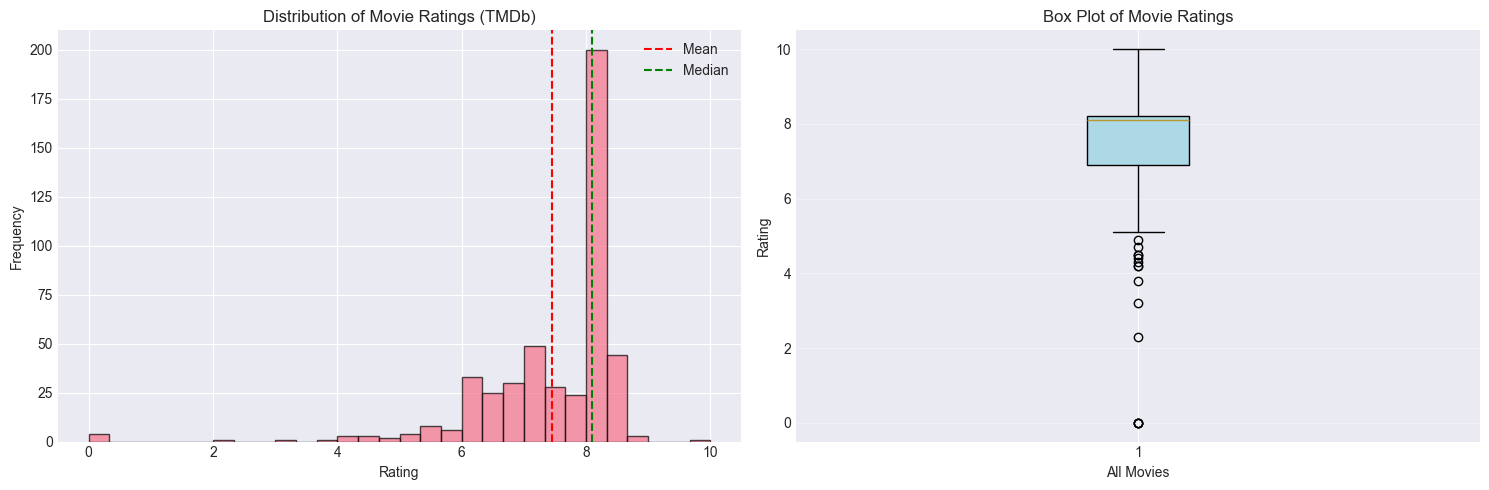

Mean rating: 7.46
Median rating: 8.10
Std deviation: 1.20


In [6]:
# Distribution of ratings
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_movies['vote_average'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Movie Ratings (TMDb)')
axes[0].axvline(df_movies['vote_average'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(df_movies['vote_average'].median(), color='green', linestyle='--', label='Median')
axes[0].legend()

# Box plot
bp = axes[1].boxplot(df_movies['vote_average'].dropna(), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_ylabel('Rating')
axes[1].set_xlabel('All Movies')
axes[1].set_title('Box Plot of Movie Ratings')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean rating: {df_movies['vote_average'].mean():.2f}")
print(f"Median rating: {df_movies['vote_average'].median():.2f}")
print(f"Std deviation: {df_movies['vote_average'].std():.2f}")

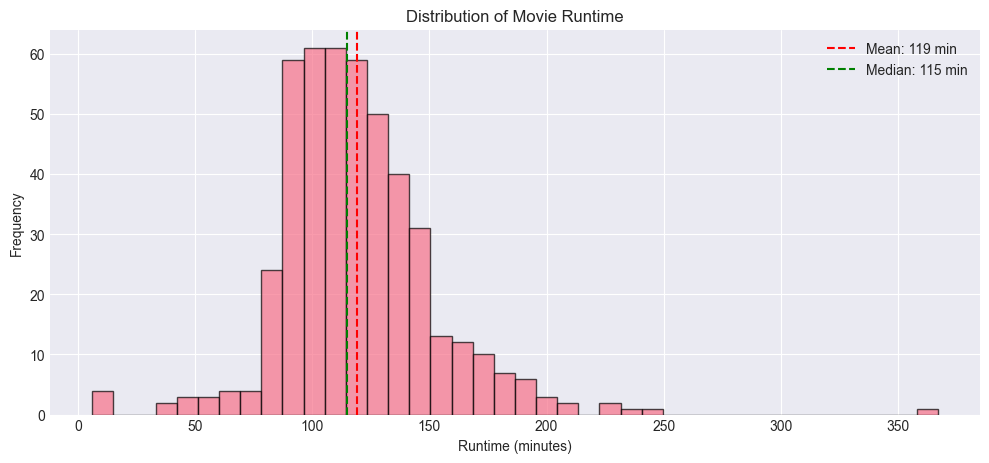

In [7]:
# Runtime distribution
plt.figure(figsize=(12, 5))

runtime_data = df_movies['runtime'].dropna()
runtime_data = runtime_data[runtime_data > 0]  # Remove invalid values

plt.hist(runtime_data, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime')
plt.axvline(runtime_data.mean(), color='red', linestyle='--', label=f'Mean: {runtime_data.mean():.0f} min')
plt.axvline(runtime_data.median(), color='green', linestyle='--', label=f'Median: {runtime_data.median():.0f} min')
plt.legend()
plt.show()

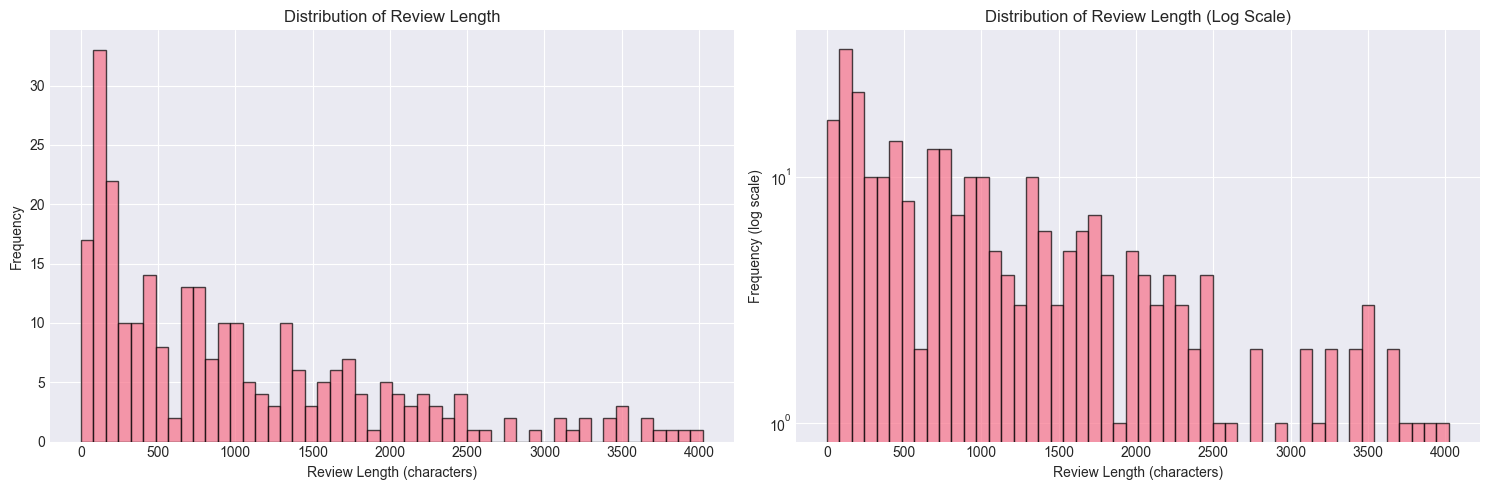

Average review length: 1018 characters
Median review length: 749 characters


In [8]:
# Review text length distribution
if 'text_length' in df_reviews.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(df_reviews['text_length'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Review Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Review Length')
    
    # Log scale
    axes[1].hist(df_reviews['text_length'], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Review Length (characters)')
    axes[1].set_ylabel('Frequency (log scale)')
    axes[1].set_title('Distribution of Review Length (Log Scale)')
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average review length: {df_reviews['text_length'].mean():.0f} characters")
    print(f"Median review length: {df_reviews['text_length'].median():.0f} characters")

## 3. Bivariate Analysis

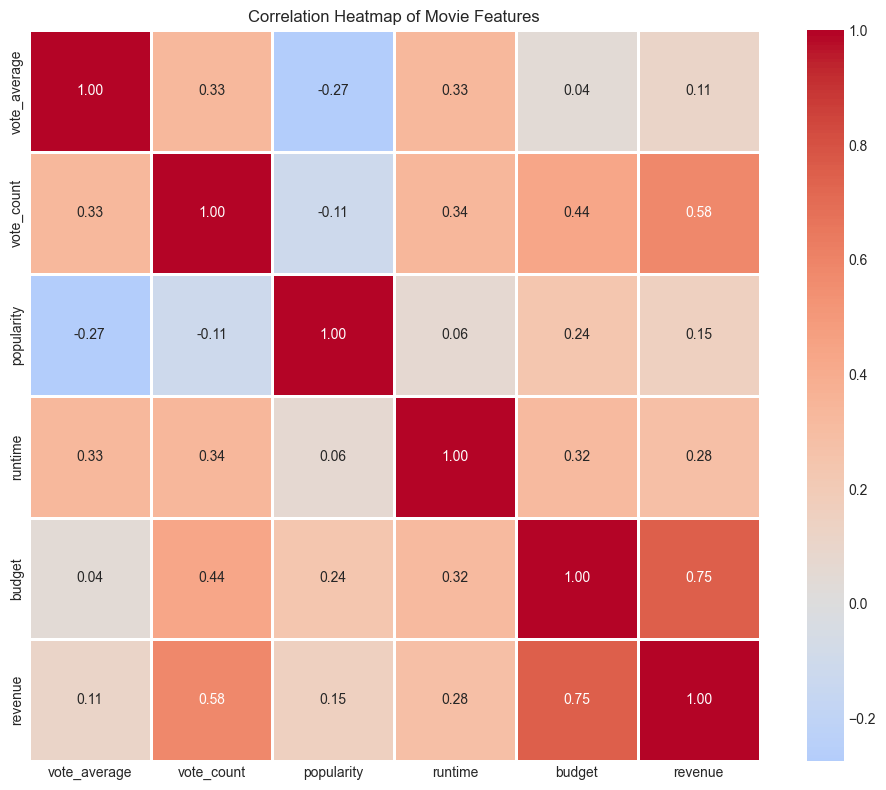

In [9]:
# Correlation heatmap for numerical features
numeric_cols = ['vote_average', 'vote_count', 'popularity', 'runtime', 'budget', 'revenue']
corr_data = df_movies[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Heatmap of Movie Features')
plt.tight_layout()
plt.show()

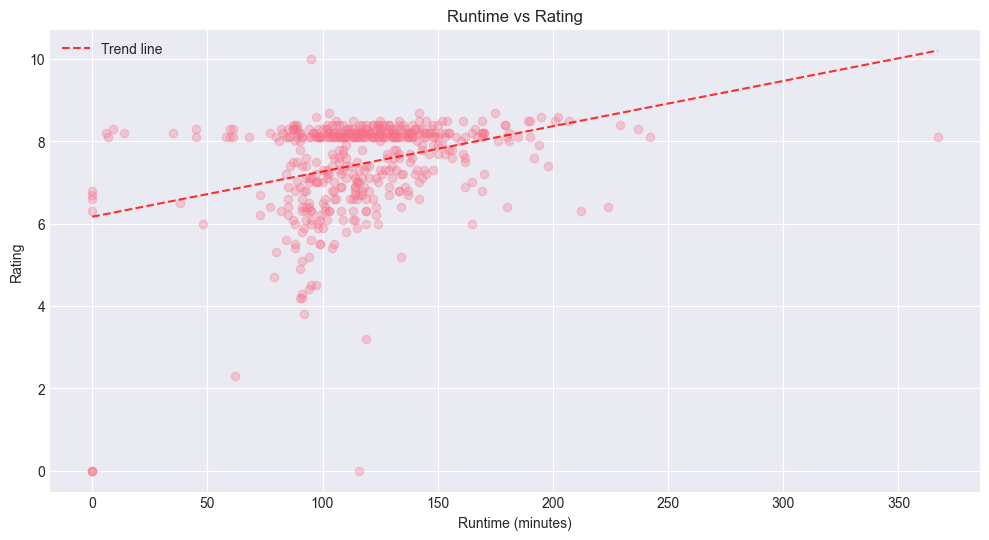

Correlation between runtime and rating: 0.333


In [10]:
# Runtime vs Rating
plt.figure(figsize=(12, 6))
plt.scatter(df_movies['runtime'], df_movies['vote_average'], alpha=0.3)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Rating')
plt.title('Runtime vs Rating')

# Add trend line
valid_data = df_movies[['runtime', 'vote_average']].dropna()
z = np.polyfit(valid_data['runtime'], valid_data['vote_average'], 1)
p = np.poly1d(z)
plt.plot(valid_data['runtime'].sort_values(), p(valid_data['runtime'].sort_values()), 
         "r--", alpha=0.8, label='Trend line')
plt.legend()
plt.show()

# Correlation
corr = valid_data['runtime'].corr(valid_data['vote_average'])
print(f"Correlation between runtime and rating: {corr:.3f}")

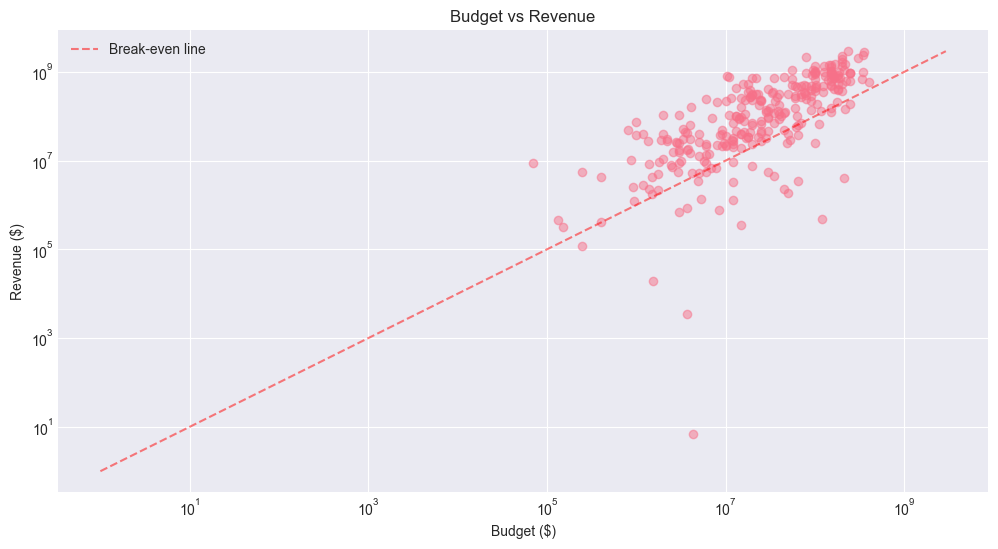

Average ROI: 714.3%
Median ROI: 339.2%


In [11]:
# Budget vs Revenue (if available)
budget_revenue = df_movies[['budget', 'revenue']].dropna()
budget_revenue = budget_revenue[(budget_revenue['budget'] > 0) & (budget_revenue['revenue'] > 0)]

if len(budget_revenue) > 0:
    plt.figure(figsize=(12, 6))
    plt.scatter(budget_revenue['budget'], budget_revenue['revenue'], alpha=0.5)
    plt.xlabel('Budget ($)')
    plt.ylabel('Revenue ($)')
    plt.title('Budget vs Revenue')
    plt.xscale('log')
    plt.yscale('log')
    
    # ROI line (break-even)
    max_val = max(budget_revenue['budget'].max(), budget_revenue['revenue'].max())
    plt.plot([1, max_val], [1, max_val], 'r--', alpha=0.5, label='Break-even line')
    plt.legend()
    plt.show()
    
    # ROI calculation
    budget_revenue['roi'] = (budget_revenue['revenue'] - budget_revenue['budget']) / budget_revenue['budget'] * 100
    print(f"Average ROI: {budget_revenue['roi'].mean():.1f}%")
    print(f"Median ROI: {budget_revenue['roi'].median():.1f}%")

## 4. Genre Analysis

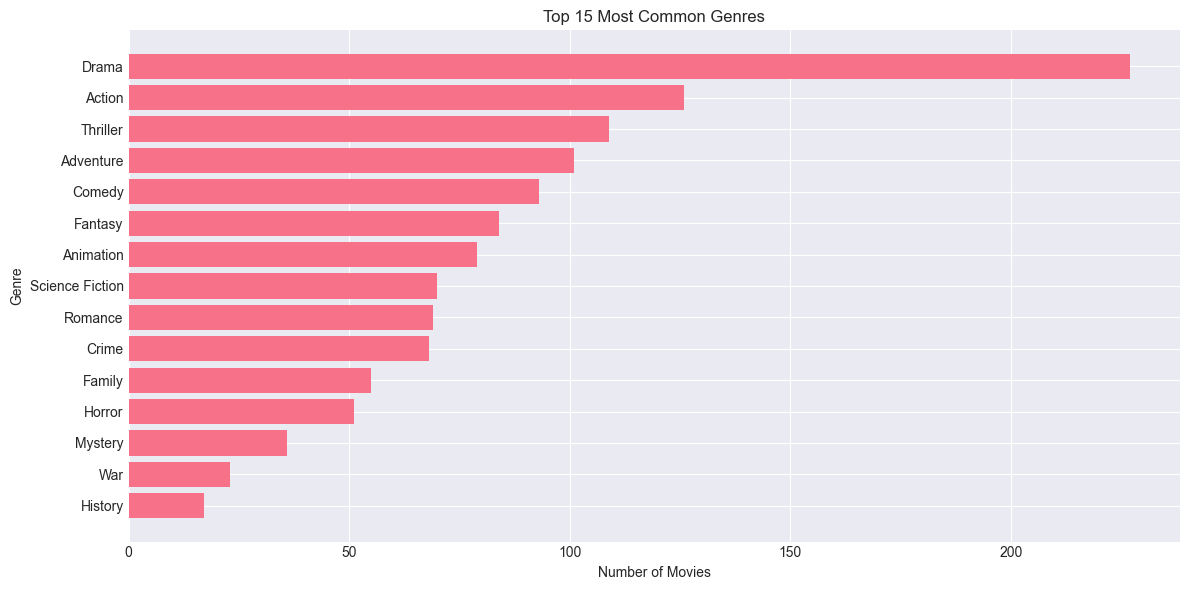

In [12]:
# Extract and count genres
from collections import Counter

all_genres = []
for genres in df_movies['genres'].dropna():
    if isinstance(genres, list):
        all_genres.extend(genres)

genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])

# Plot genre distribution
plt.figure(figsize=(12, 6))
plt.barh(genre_df['Genre'], genre_df['Count'])
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Top 15 Most Common Genres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

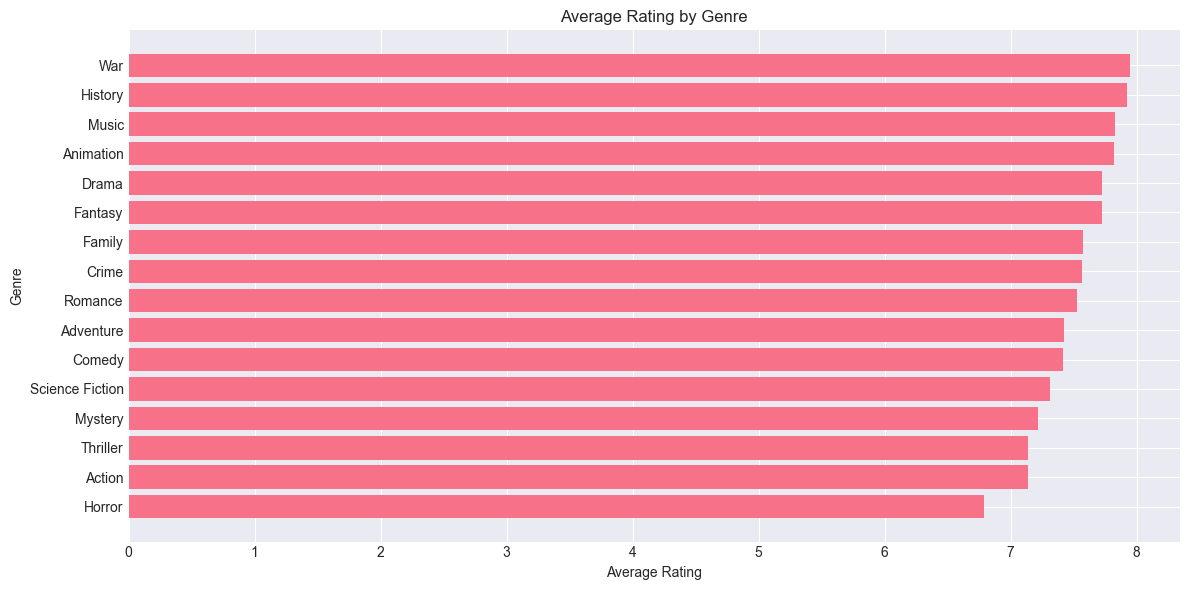


Top 5 genres by average rating:
        Genre  Avg_Rating
12        War    7.947826
14    History    7.923529
15      Music    7.829412
5   Animation    7.818987
4       Drama    7.729956


In [13]:
# Average rating by genre
genre_ratings = {}

for idx, row in df_movies.iterrows():
    # Extract scalar values
    genres = row['genres']
    vote_avg = row['vote_average']

    # Check if values are not None/NaN
    if genres is not None and vote_avg is not None:
        if isinstance(genres, list):
            for genre in genres:
                if genre not in genre_ratings:
                    genre_ratings[genre] = []
                genre_ratings[genre].append(float(vote_avg))

# Calculate average ratings
genre_avg = {genre: np.mean(ratings) for genre, ratings in genre_ratings.items() if len(ratings) > 10}
genre_avg_df = pd.DataFrame(list(genre_avg.items()), columns=['Genre', 'Avg_Rating'])
genre_avg_df = genre_avg_df.sort_values('Avg_Rating', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(genre_avg_df['Genre'], genre_avg_df['Avg_Rating'])
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 5 genres by average rating:")
print(genre_avg_df.head())

## 5. Temporal Analysis

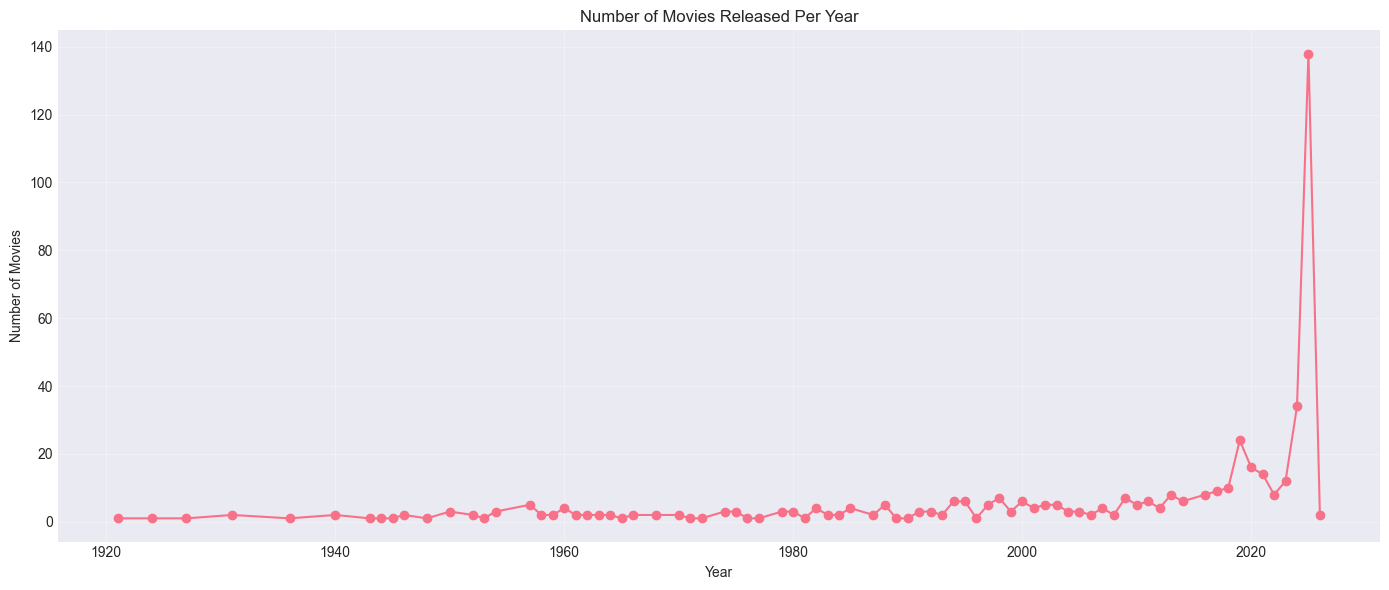

In [14]:
# Convert release_date to datetime
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')
df_movies['release_year'] = df_movies['release_date'].dt.year

# Movies per year
movies_per_year = df_movies.groupby('release_year').size()

plt.figure(figsize=(14, 6))
movies_per_year.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released Per Year')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

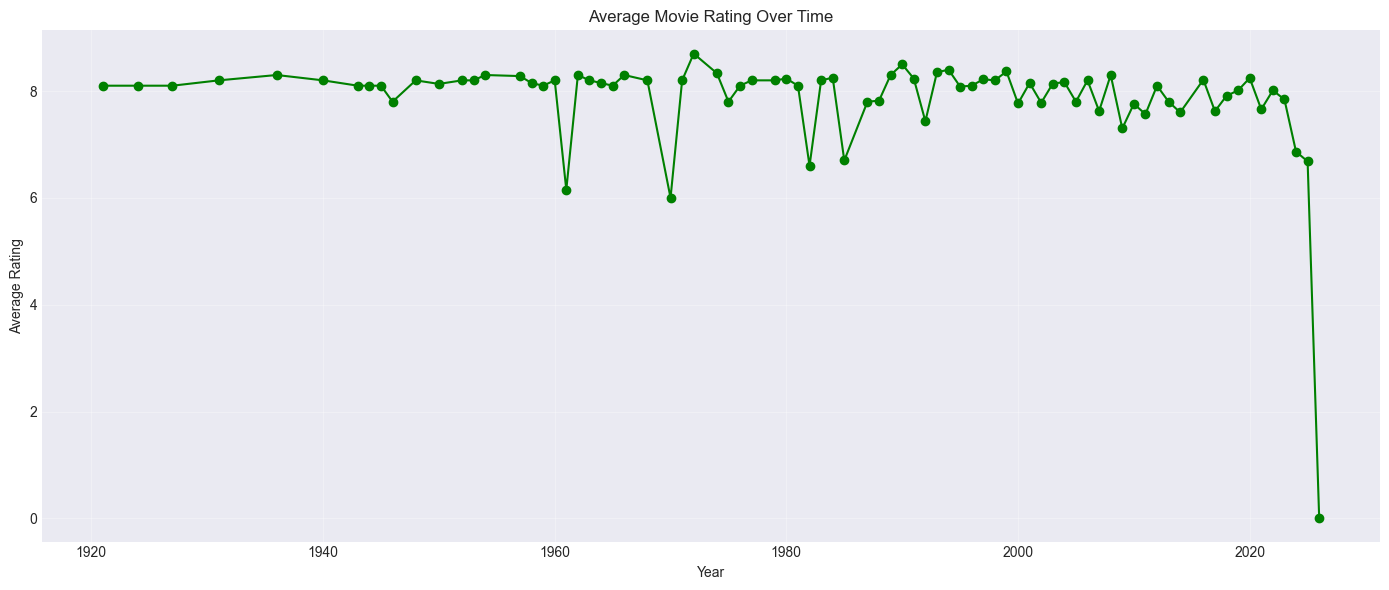

In [15]:
# Average rating over time
avg_rating_per_year = df_movies.groupby('release_year')['vote_average'].mean()

plt.figure(figsize=(14, 6))
avg_rating_per_year.plot(kind='line', marker='o', color='green')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Statistical Tests

In [16]:
# Chi-squared test: Genre vs High/Low Rating
# Create binary rating (high/low)
df_movies['rating_category'] = df_movies['vote_average'].apply(
    lambda x: 'High' if x >= 7.0 else 'Low' if pd.notna(x) else None
)

# Create genre-rating contingency table for top genres
top_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance']

for genre in top_genres:
    df_movies[f'is_{genre}'] = df_movies['genres'].apply(
        lambda x: genre in x if isinstance(x, list) else False
    )

print("\n=== Chi-Squared Tests (Genre vs Rating Category) ===")
for genre in top_genres:
    contingency = pd.crosstab(
        df_movies[f'is_{genre}'],
        df_movies['rating_category']
    )
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    print(f"\n{genre}:")
    print(f"  Chi² = {chi2:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")


=== Chi-Squared Tests (Genre vs Rating Category) ===

Drama:
  Chi² = 27.7242
  p-value = 0.0000
  Significant: Yes

Comedy:
  Chi² = 0.4586
  p-value = 0.4983
  Significant: No

Action:
  Chi² = 14.6331
  p-value = 0.0001
  Significant: Yes

Thriller:
  Chi² = 21.2418
  p-value = 0.0000
  Significant: Yes

Romance:
  Chi² = 2.4620
  p-value = 0.1166
  Significant: No



=== ANOVA Test (Rating across genres) ===
F-statistic: 7.6429
p-value: 0.0000
Significant difference: Yes


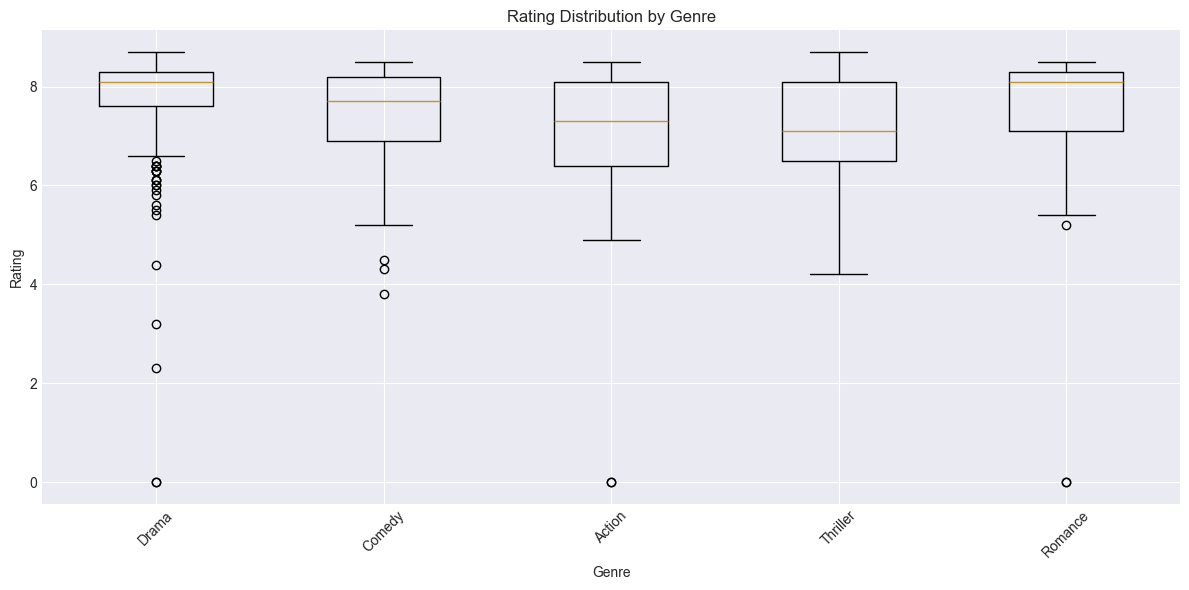

In [17]:
# ANOVA: Rating differences across genres
# Prepare data for top 5 genres
genre_groups = []
for genre in top_genres:
    genre_ratings_list = df_movies[df_movies[f'is_{genre}']]['vote_average'].dropna()
    genre_groups.append(genre_ratings_list)

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*genre_groups)

print("\n=== ANOVA Test (Rating across genres) ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Box plot for visualization
plt.figure(figsize=(12, 6))
data_for_plot = [group for group in genre_groups]
plt.boxplot(data_for_plot, labels=top_genres)
plt.ylabel('Rating')
plt.xlabel('Genre')
plt.title('Rating Distribution by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Correlation tests with p-values
print("\n=== Correlation Tests ===")

# Runtime vs Rating
valid_data = df_movies[['runtime', 'vote_average']].dropna()
corr, p_value = stats.pearsonr(valid_data['runtime'], valid_data['vote_average'])
print(f"\nRuntime vs Rating:")
print(f"  Correlation: {corr:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Vote count vs Rating
valid_data2 = df_movies[['vote_count', 'vote_average']].dropna()
corr2, p_value2 = stats.pearsonr(valid_data2['vote_count'], valid_data2['vote_average'])
print(f"\nVote Count vs Rating:")
print(f"  Correlation: {corr2:.4f}")
print(f"  p-value: {p_value2:.4f}")
print(f"  Significant: {'Yes' if p_value2 < 0.05 else 'No'}")


=== Correlation Tests ===

Runtime vs Rating:
  Correlation: 0.3334
  p-value: 0.0000
  Significant: Yes

Vote Count vs Rating:
  Correlation: 0.3343
  p-value: 0.0000
  Significant: Yes


## 7. Summary Statistics

In [19]:
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nTotal movies: {len(df_movies)}")
print(f"Total reviews: {len(df_reviews)}")

print(f"\nRating statistics:")
print(f"  Mean: {df_movies['vote_average'].mean():.2f}")
print(f"  Median: {df_movies['vote_average'].median():.2f}")
print(f"  Std Dev: {df_movies['vote_average'].std():.2f}")
print(f"  Min: {df_movies['vote_average'].min():.2f}")
print(f"  Max: {df_movies['vote_average'].max():.2f}")

print(f"\nMost common genre: {genre_df.iloc[0]['Genre']}")
print(f"Highest rated genre: {genre_avg_df.iloc[0]['Genre']} ({genre_avg_df.iloc[0]['Avg_Rating']:.2f})")

if 'text_length' in df_reviews.columns:
    print(f"\nAverage review length: {df_reviews['text_length'].mean():.0f} characters")
    print(f"Median review length: {df_reviews['text_length'].median():.0f} characters")


SUMMARY STATISTICS

Total movies: 470
Total reviews: 269

Rating statistics:
  Mean: 7.46
  Median: 8.10
  Std Dev: 1.20
  Min: 0.00
  Max: 10.00

Most common genre: Drama
Highest rated genre: War (7.95)

Average review length: 1018 characters
Median review length: 749 characters
